# Modelo de Pairs Trading Baseado em Cointegração

**Autores: Alexandre Fernandes Theoharidis, Débora Darin e Nelly Pires Colnaghi**

## Introdução

Detalhar ideia do projeto (pairs trading):

1) Pairs trading
2) Cointegração
3) Threshold
4) KNN
5) Filtro de Kalman

O presente código é a implementação de um modelo de pairs trading utilizando cointegração. As principais referências para sua elaboração são . 

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

## Bibliotecas

Abaixo estão todas as bibliotecas utilizadas no código.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.statespace.sarimax import SARIMAX # Modelos SARIMA 
import statsmodels.formula.api as smf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pykalman import KalmanFilter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

## Configurações

As configurações necessárias às bibliotecas empregadas no modelo estão consolidadas abaixo.

In [2]:
# Comando para que os gráficos sejam exibidos no corpo do texto
%matplotlib inline 

In [3]:
plt.rcParams['figure.dpi'] = 200 # Resolução dos gráficos impressos no pdf (dpi)

In [4]:
# Estilo dos gráficos
sns.set(color_codes = True)

## Parâmetros

Esses são os parâmetros referentes aos modelos de pairs trading que são implementados no código, a serem detalhados mais a frente.

In [38]:
alfa = 0.01 # Nível de significância utilizado nos testes de hipótese 
janela_dados = 126 # tamanho da janela de dados utilizada para estimação dos modelos
janela_desloc = 30 # número de períodos de deslocamento da janela móvel a cada iteração no cálculo do spread pelo OLS
janela_update = 60 # número de dias da janela de atualização dos coeficientes e do spread no método OLS
janela_coint = 5 # janela de dias que será analisada para determinação da cointegração das ações de um par
cost = 0.0005 # custo de execução 
th_OLS = 2 # Número de desvios-padrão de distância da média para abertura de posição 

## Importação e Tratamento dos Dados

Os dados utilizados nesse projeto compreendem séries de preços de ações de empresas listadas no mercado brasileiro, abrangendo o período de janeiro de 2008 a março de 2020. 

Na base importada, os pares a serem analisados já estão ordenados lado a lado para facilitar a leitura de dados. 

In [6]:
# Leitura da planilha com as séries de preços diários das ações de cada par

str_dir = 'D:/Estudos/2 Mestrado/Insper/Disciplinas/Finanças Quantitativas/Projeto/'
str_plan_bd_stocks = 'BD_Stocks_v2'

df_prices = pd.read_csv(filepath_or_buffer = str_dir + str_plan_bd_stocks + '.csv', sep=';')
df_prices.index = df_prices['Dates']
df_prices.index = pd.to_datetime(df_prices['Dates'])
df_prices = df_prices.drop(columns=['Dates'])
df_prices = df_prices.dropna()

In [7]:
# Log preços - serão usados nos testes de cointegração
df_log_prices = np.log(df_prices)
df_log_prices.head()

,PETR3 BZ Equity,PETR4 BZ Equity,ITUB4 BZ Equity,BBDC4 BZ Equity,ITUB4 BZ Equity.1,BBAS3 BZ Equity,BBDC4 BZ Equity.1,BBAS3 BZ Equity.1,GOAU4 BZ Equity,GGBR4 BZ Equity,CSNA3 BZ Equity,USIM5 BZ Equity,ELET3 BZ Equity,ELET6 BZ Equity,BRML3 BZ Equity,MULT3 BZ Equity,MULT3 BZ Equity.1,IGTA3 BZ Equity,TAEE11 BZ Equity,TRPL4 BZ Equity
Dates,,,,,,,,,,,,,,,,,,,,
2008-01-01,3.960813,3.788725,2.712573,2.693884,2.712573,3.414443,2.693884,3.414443,3.559596,3.257327,3.268313,3.285075,3.174464,3.132054,2.082811,1.949902,1.949902,2.674149,2.335343,2.260408
2008-02-01,3.954220,3.772761,2.668061,2.621984,2.668061,3.394508,2.621984,3.394508,3.523739,3.223863,3.251808,3.264002,3.147766,3.136407,2.050656,1.916776,1.916776,2.631889,2.252659,2.242198
2008-03-01,3.939638,3.756538,2.649008,2.601207,2.649008,3.379293,2.601207,3.379293,3.546826,3.256172,3.272720,3.277673,3.139183,3.125488,2.017832,1.987326,1.987326,2.619219,2.330492,2.242410
2008-04-01,3.878466,3.706228,2.656055,2.589417,2.656055,3.367641,2.589417,3.367641,3.521111,3.218876,3.240050,3.247580,3.128732,3.118879,1.972830,1.964311,1.964311,2.613740,2.338628,2.234199
2008-07-01,3.843530,3.676427,2.656055,2.609923,2.656055,3.391147,2.609923,3.391147,3.494111,3.182627,3.206803,3.197938,3.141347,3.136407,1.910875,1.921617,1.921617,2.628285,2.335343,2.239006


In [8]:
# Cálculo dos retornos diários
df_returns = df_prices.pct_change()
df_returns = df_returns.iloc[1:,:] # exclui a primeira linha que não possui retornos
df_log_returns = np.log(1+df_returns)
df_log_returns.head()

,PETR3 BZ Equity,PETR4 BZ Equity,ITUB4 BZ Equity,BBDC4 BZ Equity,ITUB4 BZ Equity.1,BBAS3 BZ Equity,BBDC4 BZ Equity.1,BBAS3 BZ Equity.1,GOAU4 BZ Equity,GGBR4 BZ Equity,CSNA3 BZ Equity,USIM5 BZ Equity,ELET3 BZ Equity,ELET6 BZ Equity,BRML3 BZ Equity,MULT3 BZ Equity,MULT3 BZ Equity.1,IGTA3 BZ Equity,TAEE11 BZ Equity,TRPL4 BZ Equity
Dates,,,,,,,,,,,,,,,,,,,,
2008-02-01,-0.006593,-0.015964,-0.044512,-0.071900,-0.044512,-0.019934,-0.071900,-0.019934,-0.035857,-0.033464,-0.016506,-0.021073,-0.026698,0.004353,-0.032155,-0.033127,-0.033127,-0.042260,-0.082683,-0.018210
2008-03-01,-0.014582,-0.016223,-0.019054,-0.020777,-0.019054,-0.015216,-0.020777,-0.015216,0.023087,0.032308,0.020912,0.013671,-0.008583,-0.010919,-0.032824,0.070551,0.070551,-0.012670,0.077833,0.000212
2008-04-01,-0.061172,-0.050310,0.007047,-0.011790,0.007047,-0.011652,-0.011790,-0.011652,-0.025715,-0.037296,-0.032670,-0.030093,-0.010451,-0.006609,-0.045002,-0.023015,-0.023015,-0.005479,0.008136,-0.008211
2008-07-01,-0.034936,-0.029801,0.000000,0.020506,0.000000,0.023506,0.020506,0.023506,-0.027001,-0.036249,-0.033247,-0.049642,0.012614,0.017528,-0.061955,-0.042694,-0.042694,0.014546,-0.003285,0.004807
2008-08-01,0.058443,0.053474,0.009227,0.015181,0.009227,0.020331,0.015181,0.020331,-0.007562,0.027208,0.018730,0.034880,0.000864,0.002170,0.009424,0.012076,0.012076,0.000000,0.000000,-0.010068


## Funções

### Regressão Usando Filtro de Kalman

A função abaixo implementa a regressão do log preço de uma ação contra o log preço da outra ação do par utilizando o filtro de Kalman. Ela retorna os coeficientes estimados ao longo do tempo, o resíduo (spread), as matrizes de covariância dos coeficientes e um objeto contendo o filtro de Kalman ajustado.

Essa função é empregada na função spread_KF para computar o spread de cada par de ações da base.

In [9]:
# Função que ajusta

def KFReg(y, x, delta, obs_cov, init_mean, init_cov, intercept = False, em = False):
    if intercept == True:
        obs_mat = np.vstack([x, np.ones(x.shape)]).T[:, np.newaxis]
        if em == False:
            trans_cov = delta / (1 - delta) * np.eye(2)
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 2, 
                              initial_state_mean = init_mean,
                              initial_state_covariance = init_cov,
                              transition_matrices = np.eye(2), # Essa é a matriz que define o random walk
                              observation_matrices = obs_mat,
                              observation_covariance = obs_cov,
                              transition_covariance = trans_cov)
            state_means, state_covs = kf.filter(y.values)
        else:
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 2, 
                              initial_state_mean = init_mean, 
                              initial_state_covariance = init_cov,
                              observation_matrices = obs_mat)
            state_means, state_covs = kf.filter(y.values)
        beta0 = state_means[:,1]
        beta1 = state_means[:,0]
        resid = y - beta0 - beta1*x
        return beta0, beta1, resid, state_covs, kf
    else:
        obs_mat = np.vstack([x]).T[:, np.newaxis]
        if em == False:
            trans_cov = delta / (1 - delta)
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 1, 
                              initial_state_mean = init_mean,
                              initial_state_covariance = init_cov,
                              transition_matrices = 1,
                              observation_matrices = obs_mat,
                              observation_covariance = obs_cov,
                              transition_covariance = trans_cov)
            state_means, state_covs = kf.filter(y.values)
        else:
            kf = KalmanFilter(n_dim_obs = 1, n_dim_state = 1, 
                              initial_state_mean = init_mean, 
                              initial_state_covariance = init_cov,
                              observation_matrices = obs_mat)
            state_means, state_covs = kf.em(y.values).filter(y.values)
        beta1 = state_means[:,0]
        resid = y - beta1*x
        return beta1, resid, state_covs, kf

### Cálculo do Spread de um Par de Ações Usando OLS

In [12]:
# Função para cálculo do spread
# A variável 'janela_dados' define o tamanho da janela móvel
# A variável 'janela_desloc' define o número de períodos de deslocamento da janela móvel a cada iteração
# Convenção: log_price1 é regredido contra log_price2
# A função retorna, para cada janela móvel:
    # O spread
    # O resultado do teste ADF para verificação da estacionariedade (1 = estacionário)
    # Os coeficientes da regressão: beta0 = intercepto, beta1 = beta do log_price1 contra log_price2

def spread_OLS(log_price1, log_price2, janela_dados, janela_desloc):   
    
    y = log_price1
    x = log_price2
    x = sm.add_constant(x)
    T = len(y)
    n = (T-janela_dados)//janela_desloc + 1 # Número de janelas
    
    s = pd.DataFrame(np.NaN, index = y.index, columns = ['Spread'])
    adf_res = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['ADF'])
    johansen_res = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['Johansen'])
    beta0 = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['Beta0'])
    beta1 = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['Beta1'])
    
    inicio = 0
    fim = janela_dados
    i = 0
    
    while fim <= T:
        
        results = sm.OLS(y.iloc[np.arange(inicio,fim)], 
                             x.iloc[np.arange(inicio,fim)]).fit()
        beta0.iloc[i,0] = results.params[0]
        beta1.iloc[i,0] = results.params[1]
        s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(results.resid).values
        
        adf_res.iloc[i,0] = 1*(adfuller(x = s.iloc[np.arange(inicio,fim),:], regression = 'c', autolag = 'BIC')[1] < alfa)
        
        
        data = pd.DataFrame(pd.concat([log_price1.iloc[np.arange(inicio,fim)],
                                       log_price2.iloc[np.arange(inicio,fim)]], axis = 1))
        johansen = coint_johansen(endog = data, det_order = 0, k_ar_diff = 1)
        johansen_trace_stat = johansen.lr1[0]
        johansen_trace_crit = johansen.cvt[0][1]
        johansen_res.iloc[i,0] = 1*(johansen_trace_stat > johansen_trace_crit)
        
        inicio = inicio + janela_desloc
        fim = fim + janela_desloc
        i = i + 1
    
    s = s.dropna()
    
    return s, adf_res, johansen_res, beta0, beta1

### Cálculo do Spread Usando Filtro de Kalman

In [16]:
def spread_KF(log_price1, log_price2, janela_dados, delta, obs_cov, init_mean0, init_cov, intercept = False, em = False):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    s = pd.DataFrame(np.NaN, index = y.index, columns = ['Spread'])
    adf_res = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['ADF'])
    beta0 = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['Beta0'])
    beta1 = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['Beta1'])
    
    inicio = 0
    fim = janela_dados
    i = 0
    init_mean = init_mean0
    
    while fim <= T:
        
        x_array = x.iloc[np.arange(inicio,fim)]
        y_array = y.iloc[np.arange(inicio,fim)]
        res = KFReg(y = y_array, x = x_array, 
                    delta = delta, obs_cov = obs_cov, 
                    init_mean = init_mean, init_cov = init_cov, 
                    intercept = intercept, em = em)
        if intercept == False:
            beta1.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[0]).values
            s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[1]).values
            adf_res.iloc[fim-1,0] = 1*(adfuller(x = res[1], 
                                            regression = 'c', 
                                            autolag = 'BIC')[1] < alfa)
        else:
            beta0.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[0]).values
            beta1.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[1]).values
            s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[2]).values
            adf_res.iloc[fim-1,0] = 1*(adfuller(x = res[2], 
                                            regression = 'c', 
                                            autolag = 'BIC')[1] < alfa)
        
        inicio = inicio + 1
        if intercept == False:
            init_mean = beta1.iloc[inicio,0]
        else:
            init_mean = np.array([beta1.iloc[inicio,0],
                                    beta0.iloc[inicio,0]])
        fim = fim + 1
        i = i + 1
    
    s = s.dropna()
    
    if intercept == False:
        return s, adf_res, beta1
    else:
        return s, adf_res, beta0, beta1

## Exemplo de Pair Trading - PETR3 x PETR4

In [13]:
x = df_log_prices['PETR4 BZ Equity']
x = x.diff()
x[0] = 0
x = x.cumsum()
y = df_log_prices['PETR3 BZ Equity']
y = y.diff()
y[0] = 0
y = y.cumsum()

In [14]:
# Cálculo do spread usando OLS
res_OLS = spread_OLS(y, x, janela_dados, janela_desloc)

In [21]:
# Variáveis que guardam os resultados do cálculo do spread usando OLS
s_OLS = res_OLS[0]
adf_OLS = res_OLS[1]
beta_OLS = res_OLS[4]

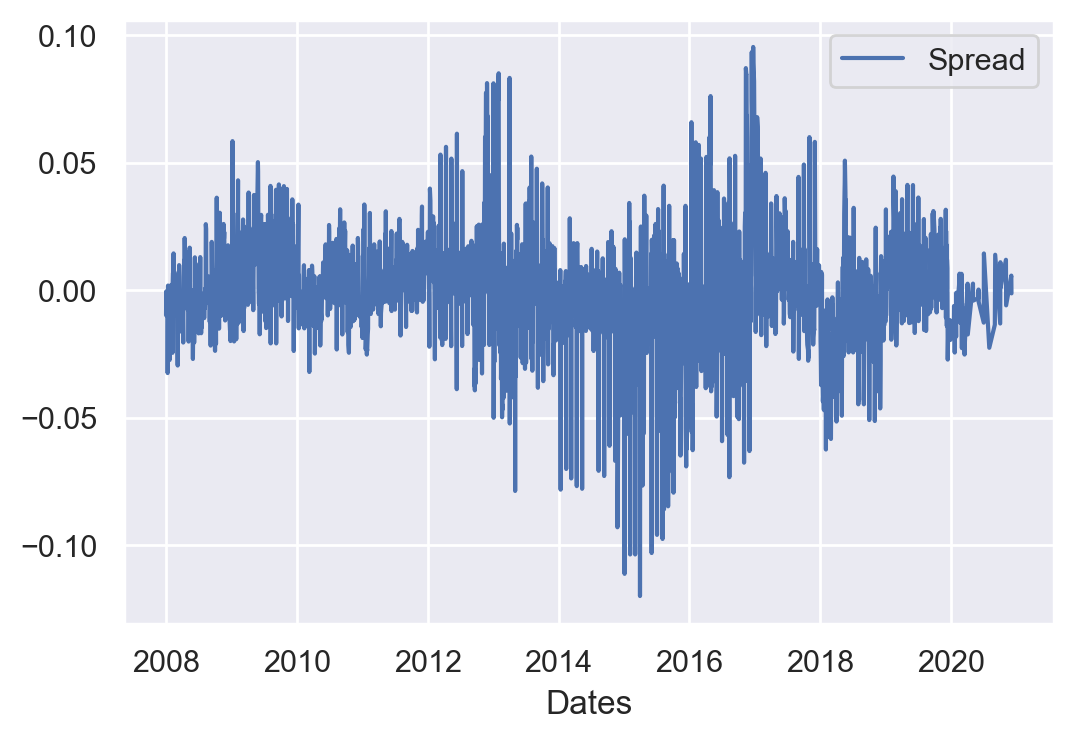

In [22]:
sns.lineplot(data = s_OLS)

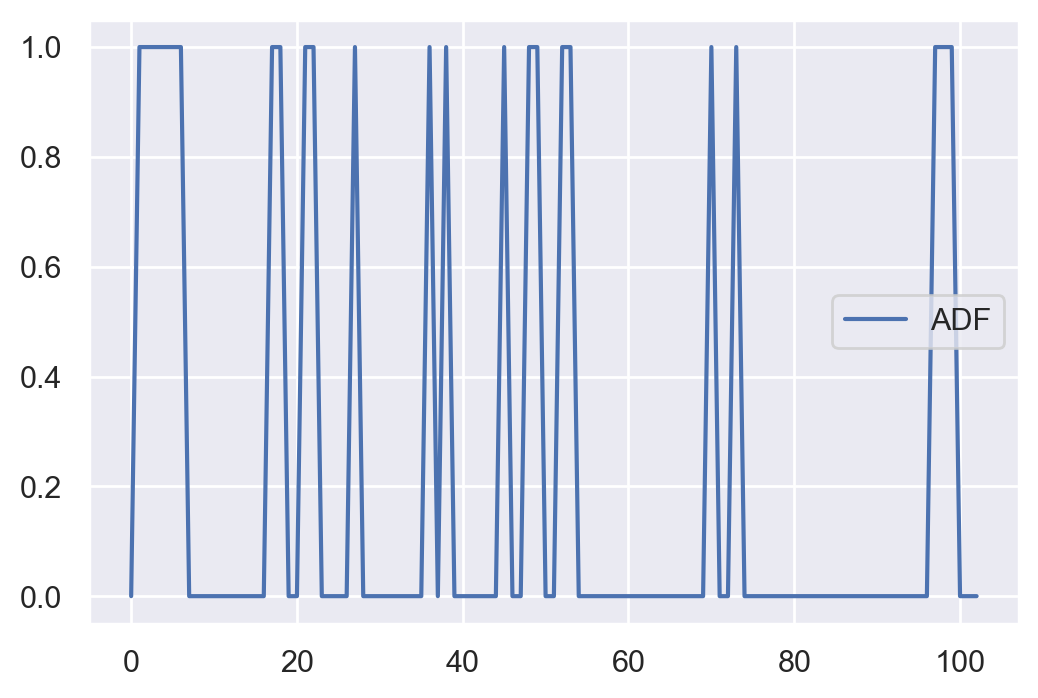

In [23]:
sns.lineplot(data = adf_OLS)

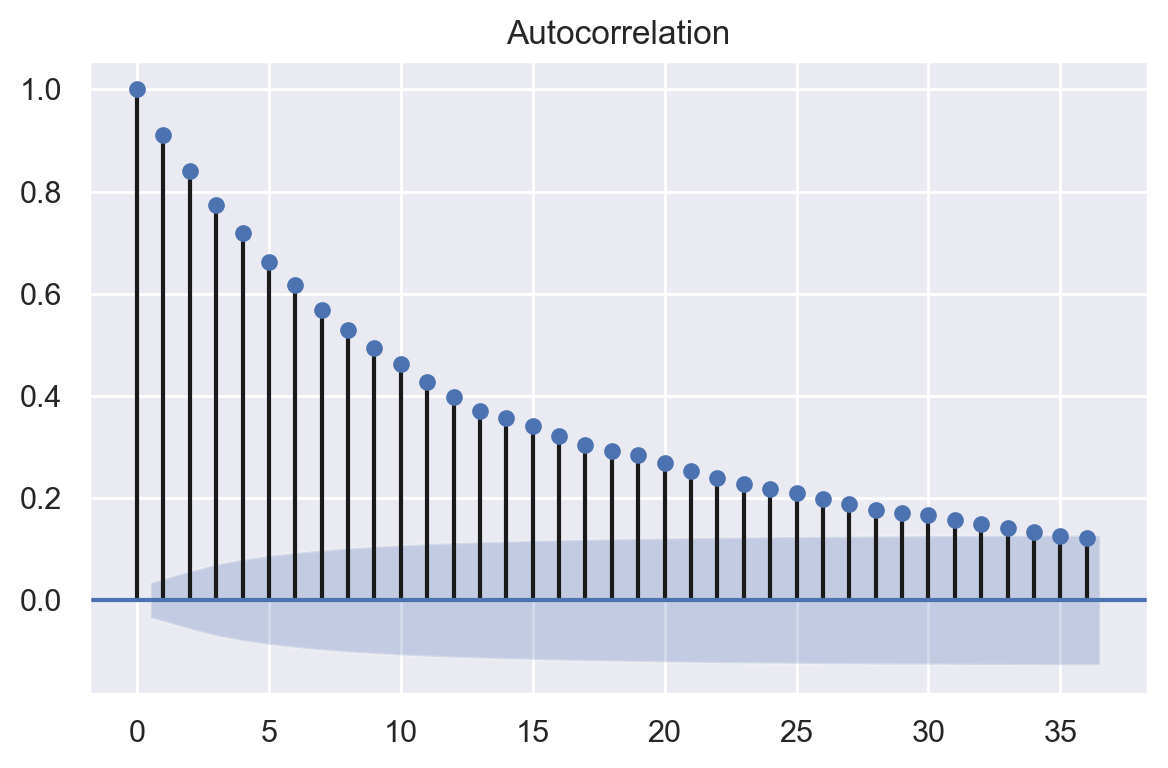

In [24]:
plot_acf(s_OLS)
plt.tight_layout()

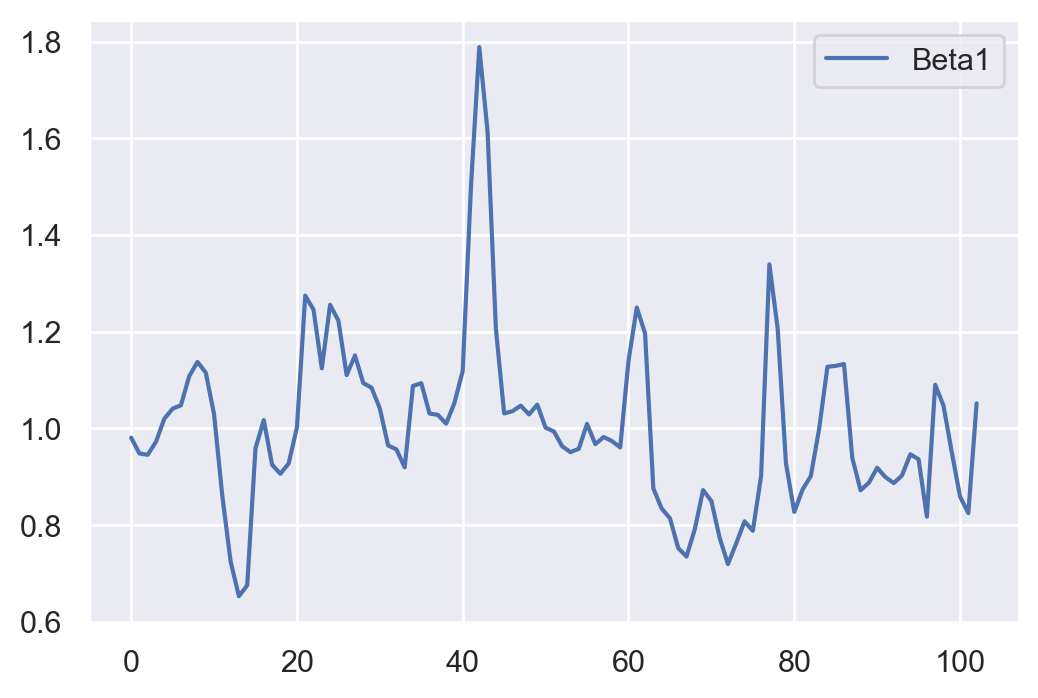

In [25]:
sns.lineplot(data = beta_OLS)

In [18]:
# Cálculo do spread usando KF
res_KF = spread_KF(y, x, janela_dados, 
                delta = 1e-2, obs_cov = 0.25, 
                #init_mean0 = 1, init_cov = 0.25,
                init_mean0 = np.array([1,0]), init_cov = np.matrix([[0.25,0],[0,0.25]]), 
                intercept = True, em = False)

In [27]:
# Variáveis que guardam os resultados do cálculo do spread usando KF
s_KF = res_KF[0]
adf_KF = res_KF[1]
beta_KF = res_KF[3]

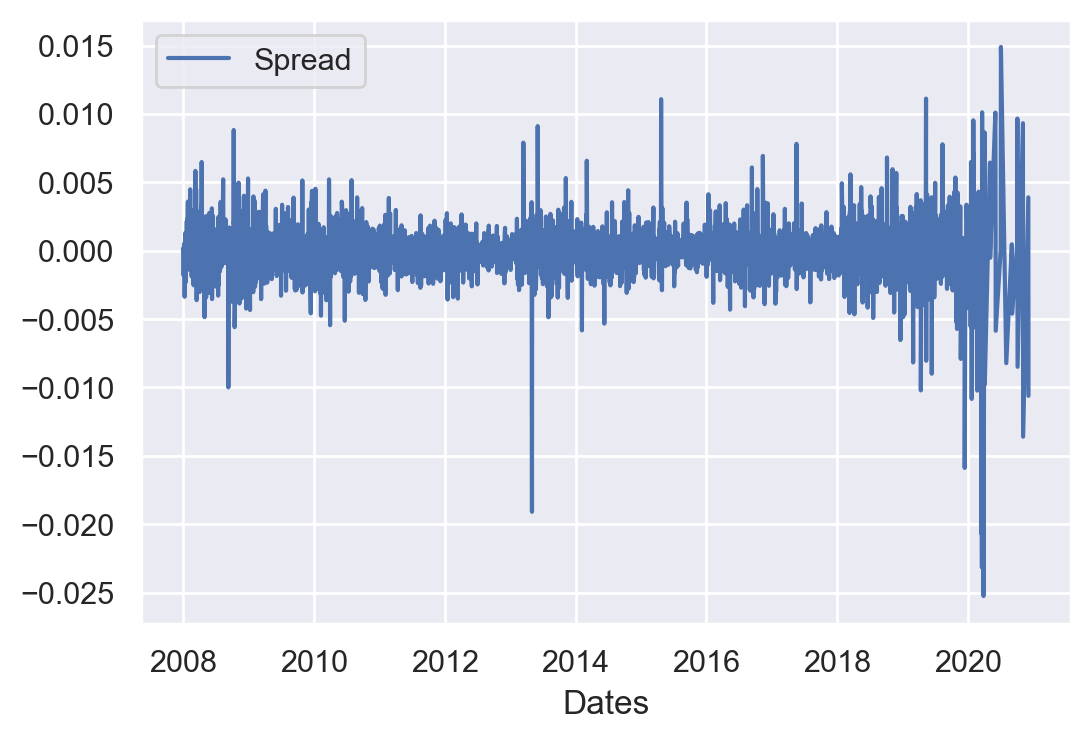

In [28]:
sns.lineplot(data = s_KF)

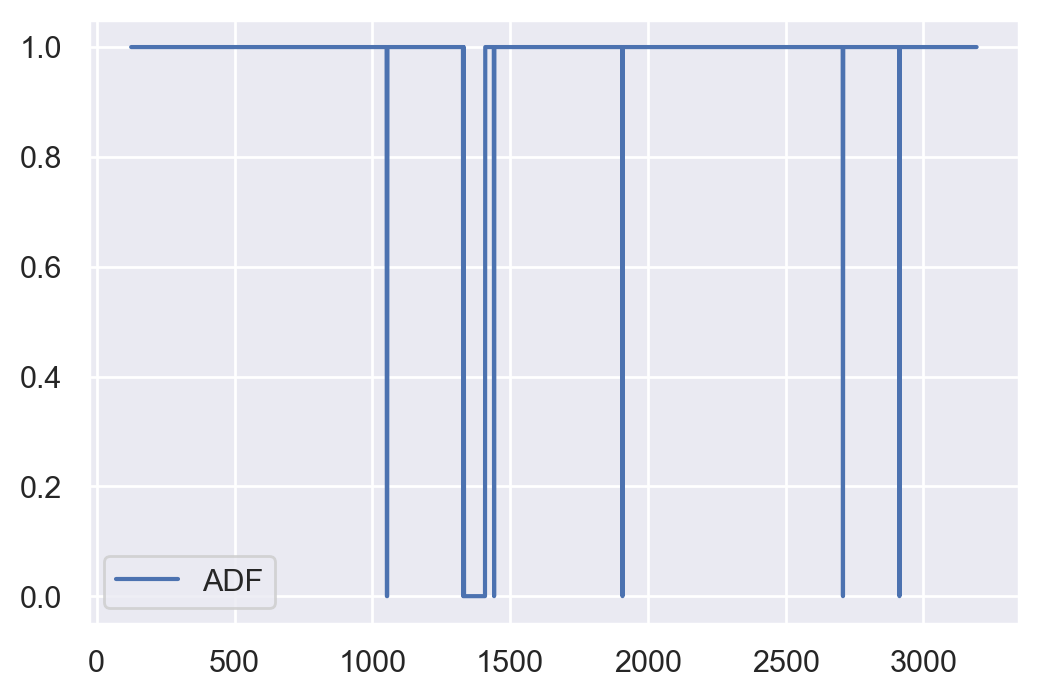

In [29]:
sns.lineplot(data = adf_KF)

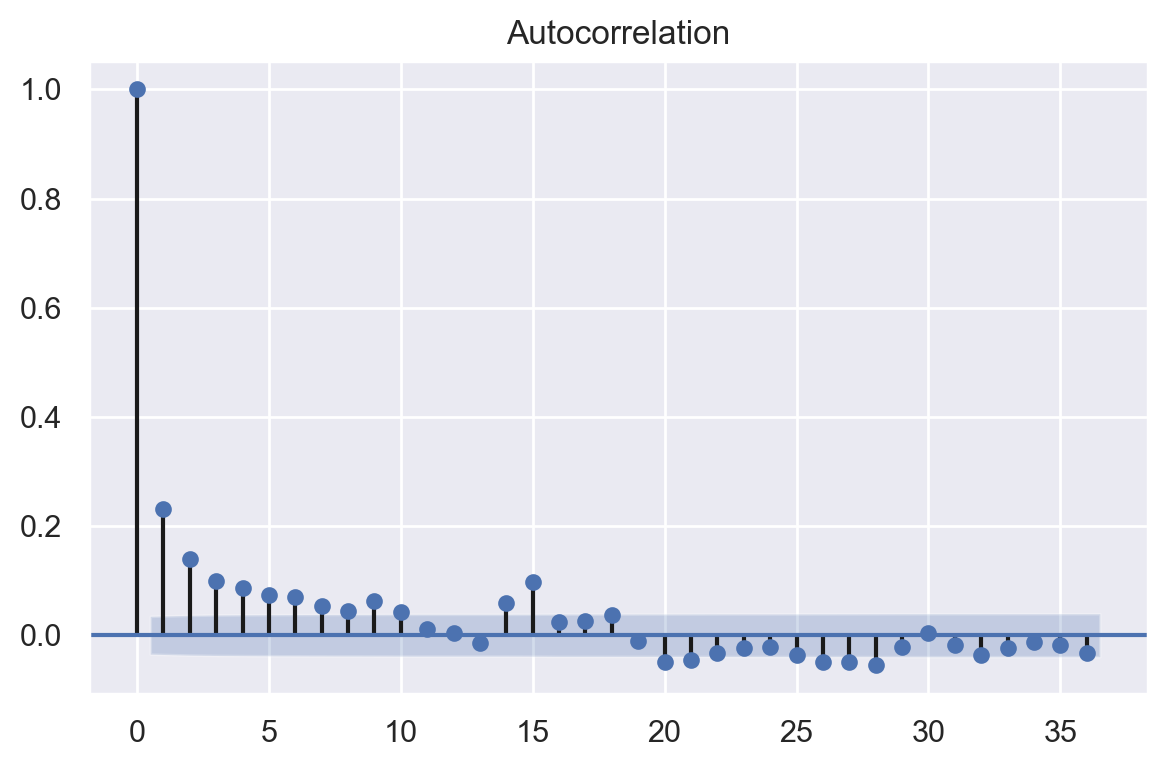

In [30]:
plot_acf(s_KF)
plt.tight_layout()

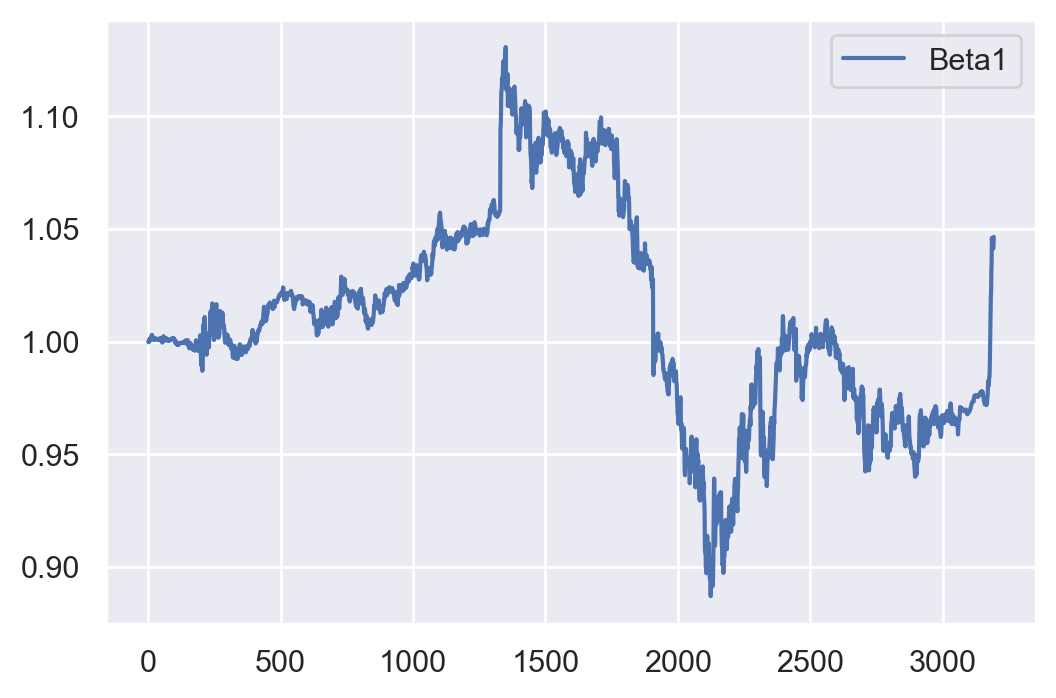

In [31]:
sns.lineplot(data = beta_KF)

## Backtest

### Função para Realização do Backtest da Estratégia Usando OLS e Thresholds

In [33]:
# Função para implementação da estratégia e do backtest
# Essa função replica a estratégia de pairs trading com custos de transação
# Os custos são aplicados somente na realização do trade, para fins de simplificação


# Melhorias:
# 1) Considerar uma banda interior
# 2) GARCH sobre o spread para estimar a vol na ponta e projetar para o período seguinte

def backtest_OLS(log_price1, log_price2, df_spread, df_beta1, df_coint_res,
                 janela_dados, janela_desloc, janela_update, cost, th):
    
    y = log_price1
    x = log_price2
    T = len(y)
    n = (T-janela_dados)//janela_desloc + 1
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    inicio_trade = fim_est 
    fim_trade = fim_est + janela_desloc
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    # -1 se o par foi aberto quando o spread estava na região inferior de fora
    # +1 se o par foi aberto quando o spread estava na região superior de fora
    pos_aberto = -1 
    
    i = 0
    k = 0
    
    while fim_trade <= T:
        
        if df_coint_res.iloc[i,0] == True:
            
            j = 0
            
            for k in np.arange(inicio_trade, fim_trade):
                    
                inicio_update = fim_est + j - janela_update
                fim_update = fim_est + j
                
                reg = sm.OLS(y.iloc[np.arange(inicio_update, fim_update)], 
                                     sm.add_constant(x.iloc[np.arange(inicio_update, fim_update)])).fit()
                beta0 = reg.params[0]
                beta1 = reg.params[1]
                avg_spread = np.mean(reg.resid)
                vol_spread = np.std(reg.resid, ddof = 1)
                spread_trade = reg.resid[-1]
                
                lim_sup = avg_spread + th*vol_spread
                lim_inf = avg_spread - th*vol_spread
                
                # Caso 1: spread na parte superior de fora da banda
                if spread_trade > lim_sup:
                    
                    # Caso 1.1: sem posição em aberto --> abre posição
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = 1
                    
                    # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
    
                # Caso 2: spread na parte superior de dentro da banda
                if spread_trade > avg_spread and spread_trade < lim_sup:
                
                    # Caso 2.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                
                # Caso 3: spread na parte inferior de dentro da banda
                if spread_trade < avg_spread and spread_trade > lim_inf:
                    
                    # Caso 3.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                # Caso 4: spread na parte inferior de fora da banda
                if spread_trade < lim_inf:
        
                    # Caso 4.1: sem posição em aberto --> abre
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = -1
                    
                    # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                j = j + 1
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[k+1,0] = -(y.iloc[k+1]-y.iloc[k]) + beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[k+1,0] = (y.iloc[k+1]-y.iloc[k]) - beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + janela_desloc
        fim_est = fim_est + janela_desloc
        inicio_trade = fim_est 
        fim_trade = fim_est + janela_desloc
        i = i + 1
        
    return df_log_retornos

In [46]:
df_log_retornos_OLS_th = backtest_OLS(y, x, s_OLS, beta_OLS, adf_OLS, janela_dados, janela_desloc, janela_update, cost, th_OLS)

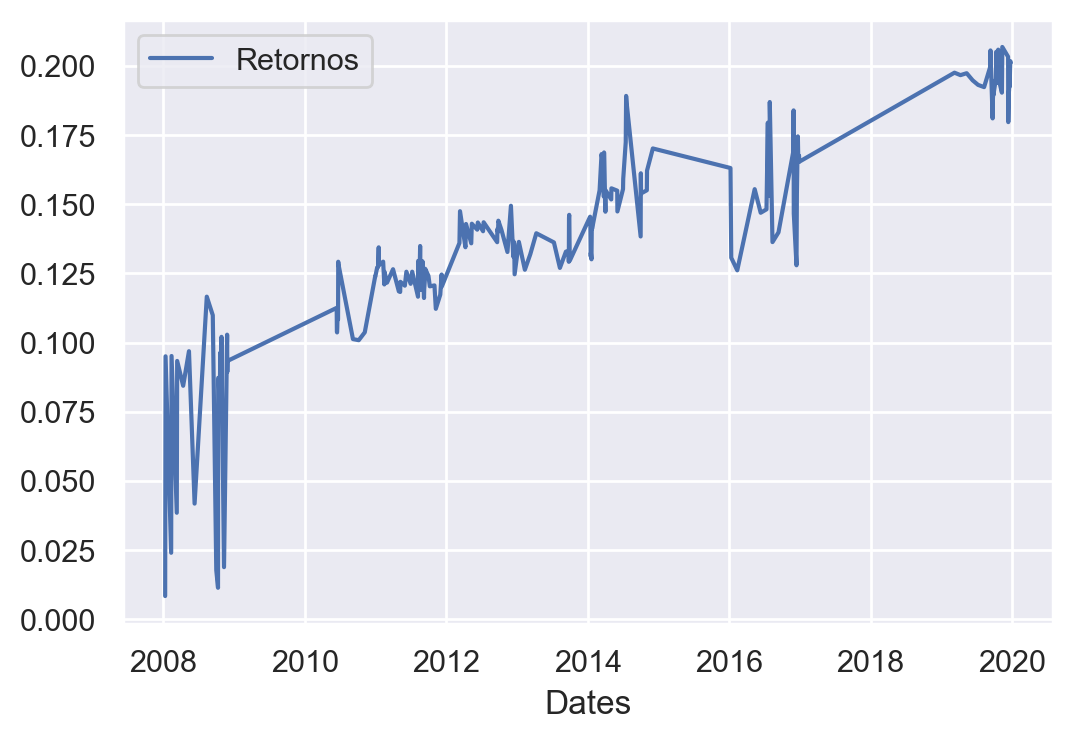

In [47]:
sns.lineplot(data=np.exp(df_log_retornos_OLS.cumsum())-1)

### Funções para Implementação do kNN

In [69]:
# Função para gerar os retornos diários da estratégia de pairs trading

def retornos_pares(df_spread, df_coint_res, janela_coint):

    T = df_coint_res.shape[0]
    
    df_retornos = pd.DataFrame(np.nan, index = df_spread.index, columns = ['Retorno'])
    
    for i in np.arange(janela_coint,T-1):
        
        if np.min(df_coint_res.iloc[np.arange(i-janela_coint, i), 0]) == True:
            
            #retorno = np.abs(df_spread.iloc[i,0])
            retorno = 0
            
            for j in np.arange(i+1,T):
                
                retorno = retorno + df_spread.iloc[j,0] - df_spread.iloc[j-1,0]
                
                if df_spread.iloc[i,0] > 0:
                    
                    if df_spread.iloc[j,0] <= 0:
                        
                        break
                        
                if df_spread.iloc[i,0] < 0:
                    
                    if df_spread.iloc[j,0] >= 0:
                        
                        break
                        
                if np.min(df_coint_res.iloc[np.arange(j-janela_coint, j), 0]) == False:
                    
                    break
                        
            h = j - i
            
            df_retornos.iloc[i,0] = retorno/h
    
    df_retornos = df_retornos.dropna()
    
    return df_retornos

In [81]:
# passar o cdi para trocar o critério

def knn_par(df_spread, df_coint_res, janela_desloc, janela_coint, k, method):
    
    if method == 'OLS':
        df_coint_res = pd.DataFrame(np.repeat(df_coint_res.values, janela_desloc))
    s_norm = (df_spread - np.mean(df_spread))/np.std(df_spread, ddof=1)
    r = retornos_pares(s_norm, df_coint_res, janela_coint)
    r = 1*(r>=np.median(r))
    yX = pd.concat([r,np.abs(s_norm).shift(-1)],axis=1,sort=True).dropna()
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh_fit = neigh.fit(yX.iloc[:,1:].values.reshape(-1,1), yX.iloc[:,0])
    
    obs_values = r
    fitted_values = neigh.predict(yX.iloc[:,1:])
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true = obs_values, y_pred = fitted_values), 
                                   index = ['Negative', 'Positive'], 
                                   columns = ['Negative', 'Positive'])
    
    return neigh_fit, df_confusion_matrix

In [98]:
# cross-validation
df_log_retornos_OLS_kNN = knn_par(s_OLS, adf_OLS, janela_desloc, janela_coint, 5, 'OLS')

In [99]:
sns.lineplot(data=np.exp(df_log_retornos_OLS_kNN.cumsum())-1)

AttributeError: 'KNeighborsClassifier' object has no attribute 'cumsum'

### Validação kNN

In [96]:
s_KF_norm = (s_KF - np.mean(s_KF))/np.std(s_KF, ddof=1)
r = retornos_pares(s_KF_norm, adf_KF, janela_coint)
r = 1*(r>=np.median(r))
yX = pd.concat([r,np.abs(s_KF_norm).shift(-1),np.abs(s_KF_norm).shift(-2)],axis=1,sort=True).dropna()

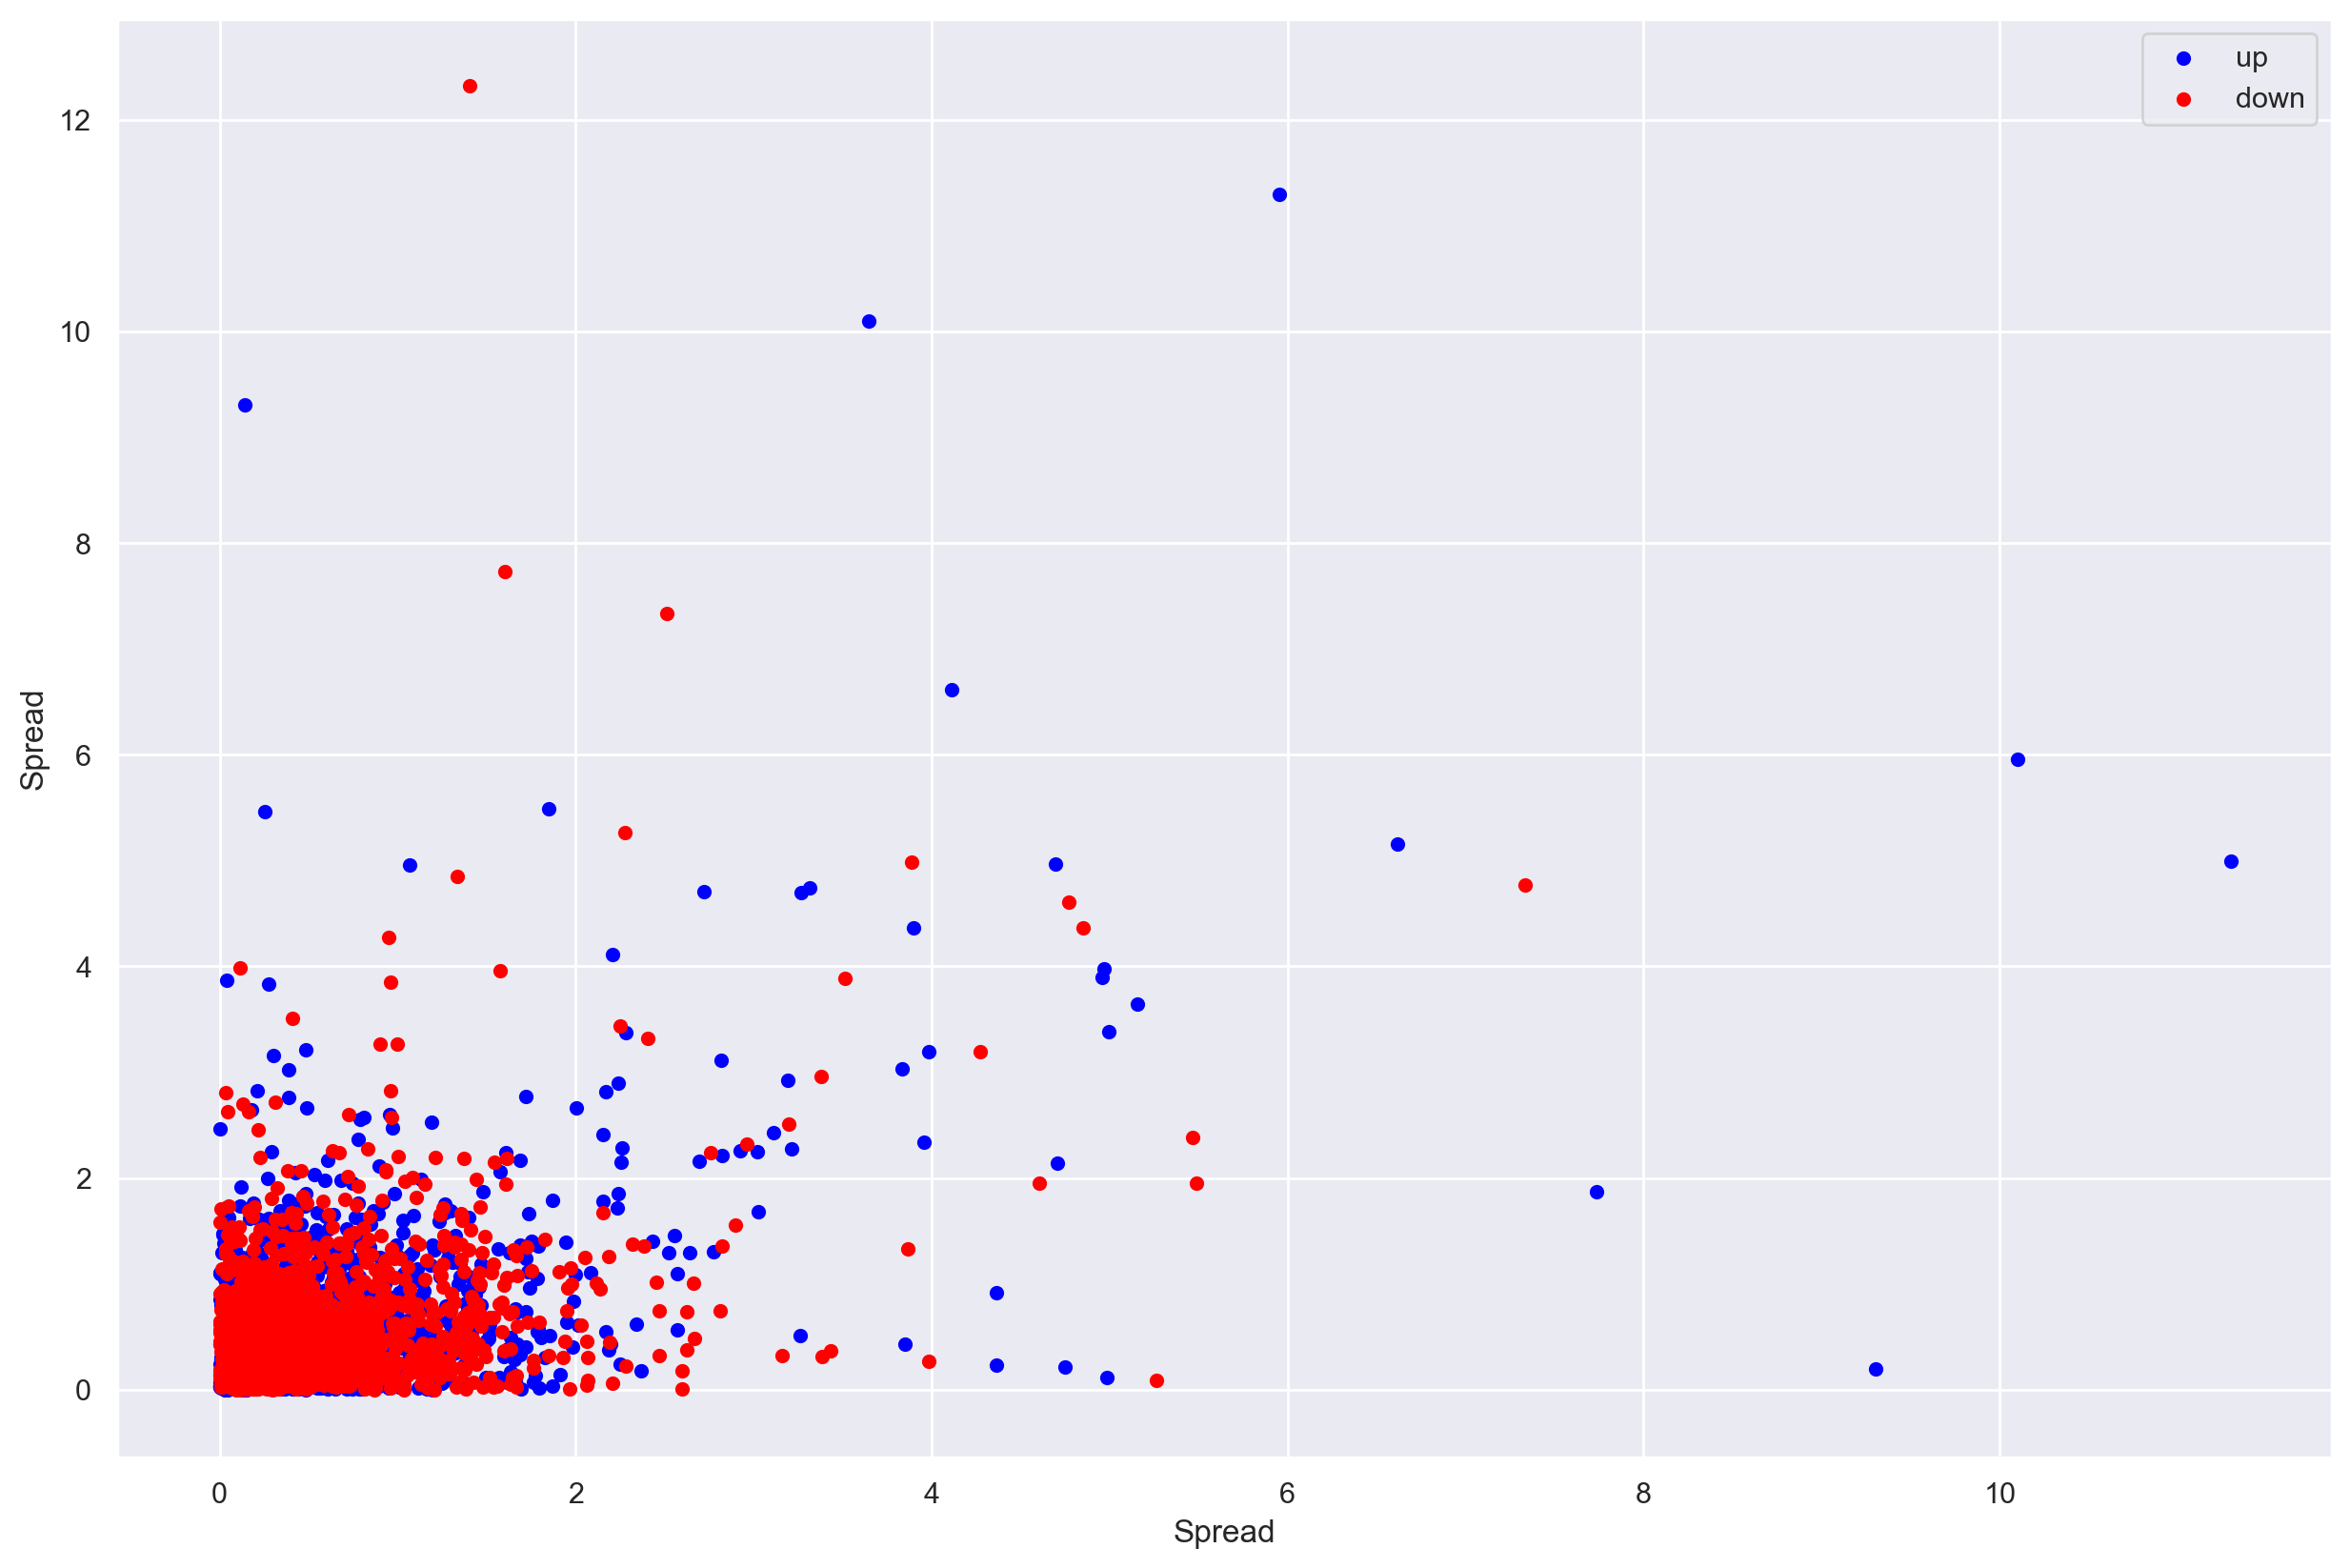

In [97]:
plt.figure(figsize=(15,10))
plot_df = yX[yX.iloc[:,0] == 1]
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], s = 20, c = 'blue', label = 'up')
plot_df = yX[yX.iloc[:,0] == 0]
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], s = 20, c = 'red', label = 'down')
plt.legend()
plt.xlabel(plot_df.columns[1])
plt.ylabel(plot_df.columns[2])
plt.show()

In [82]:
knn_OLS = knn_par(s_OLS, adf_OLS, janela_desloc, janela_coint, 5, 'OLS')

In [83]:
knn_KF = knn_par(s_KF, adf_KF, janela_desloc, janela_coint, 5, 'KF')

In [87]:
s_KF_norm = (s_KF - np.mean(s_KF))/np.std(s_KF, ddof=1)
ret = backtest_KF_knn(knn_KF, y, x, s_KF_norm, beta_KF, adf_KF, 
                janela_dados, janela_coint, 0, 0)

In [57]:
recall = TP / (TP + FN) # true positive rate
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
print(recall)
print(accuracy)
print(precision)

0.625
0.5985796415285762
0.4935767410412441


 ### Função para Realização do Backtest Usando OLS e kNN

In [ ]:
# Função não está pronta - PARAMOS AQUI

def backtest_OLS_kNN(log_price1, log_price2, df_spread, df_beta1, df_coint_res,
                 janela_dados, janela_desloc, janela_update, cost, th):
    
    y = log_price1
    x = log_price2
    T = len(y)
    n = (T-janela_dados)//janela_desloc + 1
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    inicio_trade = fim_est 
    fim_trade = fim_est + janela_desloc
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    # -1 se o par foi aberto quando o spread estava na região inferior de fora
    # +1 se o par foi aberto quando o spread estava na região superior de fora
    pos_aberto = -1 
    
    i = 0
    k = 0
    
    while fim_trade <= T:
        
        if df_coint_res.iloc[i,0] == True:
            
            j = 0
            
            for k in np.arange(inicio_trade, fim_trade):
                    
                inicio_update = fim_est + j - janela_update
                fim_update = fim_est + j
                
                reg = sm.OLS(y.iloc[np.arange(inicio_update, fim_update)], 
                                     sm.add_constant(x.iloc[np.arange(inicio_update, fim_update)])).fit()
                beta0 = reg.params[0]
                beta1 = reg.params[1]
                avg_spread = np.mean(reg.resid)
                vol_spread = np.std(reg.resid, ddof = 1)
                spread_trade = reg.resid[-1]
                
                lim_sup = avg_spread + th*vol_spread
                lim_inf = avg_spread - th*vol_spread
                
                # Caso 1: spread na parte superior de fora da banda
                if spread_trade > lim_sup:
                    
                    # Caso 1.1: sem posição em aberto --> abre posição
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = 1
                    
                    # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
    
                # Caso 2: spread na parte superior de dentro da banda
                if spread_trade > avg_spread and spread_trade < lim_sup:
                
                    # Caso 2.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                
                # Caso 3: spread na parte inferior de dentro da banda
                if spread_trade < avg_spread and spread_trade > lim_inf:
                    
                    # Caso 3.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                # Caso 4: spread na parte inferior de fora da banda
                if spread_trade < lim_inf:
        
                    # Caso 4.1: sem posição em aberto --> abre
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = -1
                    
                    # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                j = j + 1
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[k+1,0] = -(y.iloc[k+1]-y.iloc[k]) + beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[k+1,0] = (y.iloc[k+1]-y.iloc[k]) - beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + janela_desloc
        fim_est = fim_est + janela_desloc
        inicio_trade = fim_est 
        fim_trade = fim_est + janela_desloc
        i = i + 1
        
    return df_log_retornos
    

In [24]:
# Considerar o efeito sobre o custo do número de trades e ajustes causados por delta_beta_lim

def backtest_KF(log_price1, log_price2, df_spread, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, th, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    '''
    -1 se o par foi aberto quando o spread estava na região inferior de fora
    +1 se o par foi aberto quando o spread estava na região superior de fora
    '''
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-1,0]
    beta1 = df_beta1.iloc[fim_est-1,0]
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1) - (fim_est - janela_coint) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint, fim_est), 0]) == True:
            
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-1,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-1,0]
            
            avg_spread = np.mean(s.iloc[np.arange(inicio_est, fim_est)]).values
            vol_spread = np.std(s.iloc[np.arange(inicio_est, fim_est)], ddof = 1).values
            spread_trade = df_spread.iloc[fim_est-1].values
                        
            lim_sup = avg_spread + th*vol_spread
            lim_inf = avg_spread - th*vol_spread
                
            # Caso 1: spread na parte superior de fora da banda
            if spread_trade > lim_sup:
                    
                # Caso 1.1: sem posição em aberto --> abre posição
                if par_aberto == False:
                    
                    beta1 = df_beta1.iloc[fim_est-1,0]
                    par_aberto = True
                    pos_aberto = 1
                    
                # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                    
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                    
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
    
                # Caso 2: spread na parte superior de dentro da banda
                if spread_trade > avg_spread and spread_trade < lim_sup:
                
                    # Caso 2.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                    # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                
                # Caso 3: spread na parte inferior de dentro da banda
                if spread_trade < avg_spread and spread_trade > lim_inf:
                    
                    # Caso 3.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                    
                    # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
                # Caso 4: spread na parte inferior de fora da banda
                if spread_trade < lim_inf:
        
                    # Caso 4.1: sem posição em aberto --> abre
                    if par_aberto == False:
                        
                        beta1 = df_beta1.iloc[fim_est-1,0]
                        par_aberto = True
                        pos_aberto = -1
                    
                    # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                    
                    # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2 
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

In [85]:
def backtest_KF_knn(knn_fit, log_price1, log_price2, df_spread, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    '''
    -1 se o par foi aberto quando o spread estava na região inferior de fora
    +1 se o par foi aberto quando o spread estava na região superior de fora
    '''
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-1,0]
    beta1 = df_beta1.iloc[fim_est-1,0]
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1) - (fim_est - janela_coint) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint, fim_est), 0]) == True:
            
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-1,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-1,0]
            
            spread_trade = df_spread.iloc[fim_est-1].values
            
            if par_aberto == False:
                
                knn_predict = knn_fit.predict(spread_trade.reshape(-1, 1))
                
                if knn_predict == 1:
                    if spread_trade > 0:
                        pos_aberto = 1
                    else:
                        pos_aberto = -1
                    par_aberto = True
                
            else:
                
                cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                
                if pos_aberto == 1:
                    
                    if spread_trade <= 0:
                        par_aberto = False
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta - cost
                    else:
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                        
                if pos_aberto == -1:
                    
                    if spread_trade >= 0:
                        par_aberto = False
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta - cost
                    else:
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                                    
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração

        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
        
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

In [58]:
ret = backtest_KF_knn(neigh_fit, y, x, s_norm, beta1, adf, 
                janela_dados, 7, 0, 0)

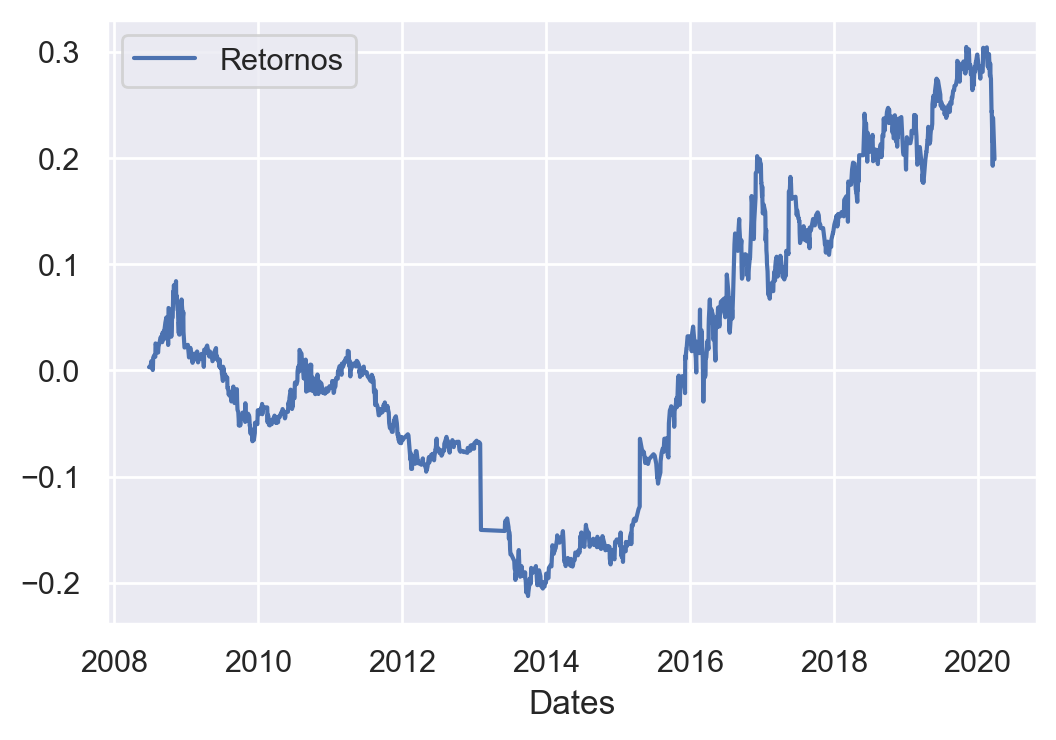

In [59]:
sns.lineplot(data = np.exp(ret.cumsum())-1)

### Funções para Análise de Performance e Risco da Estratégia

Guardar os retornos do portfólio em dataframes com os nomes df_fundo_retorno, df_fundo_retorno_mes e df_fundo_log_retorno

In [81]:
# Função para calcular o Máximo Drawdown
def MaxDD(r_cum):
    x = np.log(1+np.array(r_cum))
    mdd = 0
    pico = x[0]
    i = 0
    dt_inicio_aux = r_cum.index[0]
    for r in x:
        if r > pico:
            pico = r
            dt_inicio_aux = r_cum.index[i]
        dd = (r - pico)
        if dd < mdd:
            mdd = dd
            dt_inicio = dt_inicio_aux
            dt_fim = r_cum.index[i]
        i = i + 1
    return [np.exp(mdd) - 1, dt_inicio, dt_fim]

In [254]:
def Omega(r_port, threshold, num_steps):
    n = len(r_port)
    cols = len(r_port.columns)
    res = pd.DataFrame(np.zeros([1,cols]))
    for j in range(0,cols):
        if not math.isnan(r_port.iloc[0,j]):
            x = r_port.iloc[:,j]
            x = x[:,np.newaxis]
            avg = np.mean(x)
            vol = np.std(x)
            x_plot = np.linspace(-3.5*vol+avg, 3.5*vol+avg, num_steps) # Abrange um intervalo de 3.5 std - pode ajustar
            x_plot_low = x_plot[x_plot<=threshold]
            x_plot_high = x_plot[x_plot>threshold]
            h = 1.06*vol*n**(-1/5) # Silverman's (1986) rule of thumb
            kde = KernelDensity(kernel='gaussian', bandwidth = h).fit(x)
            dens = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
            cum_dens = sp.integrate.cumtrapz(y = dens, x = x_plot, initial = 0)
            try:
                int_low = sp.integrate.simps(cum_dens[x_plot<=threshold], x_plot_low)
                int_high = sp.integrate.simps(cum_dens[x_plot>threshold], x_plot_high)
                res.iloc[0,j]=((np.max(x_plot)-threshold)-int_high)/int_low
            except:
                res.iloc[0,j]=np.nan
    return res

In [ ]:
# Sharpe generalizado
# Preciso checar o artigo original, pois o resultado está estranho para alguns fundos
# Melhor ignorar por enquanto
def ASKSR(r_port, rf, abs_risk_aversion):
    avg = np.mean(r_port)
    var = np.var(r_port)
    skew = sp.stats.skew(r_port)
    kurt = sp.stats.kurtosis(r_port, fisher = False)
    alfa = 3*np.sqrt(3*kurt-4*skew**2-9)/(var*(3*kurt-5*skew**2-9))
    beta = 3*skew/(np.sqrt(var)*(3*kurt-5*skew**2-9))
    eta = avg - 3*skew*np.sqrt(var)/(3*kurt-4*skew**2-9)
    delta = 3*np.sqrt(var)*np.sqrt(3*kurt-5*skew**2-9)/(3*kurt-4*skew**2-9)
    phi = np.sqrt(alfa**2-beta**2)
    a = (1/abs_risk_aversion)*(beta+alfa*(eta-rf)/np.sqrt(delta**2+(eta-rf)**2))
    return np.sqrt(2*(abs_risk_aversion*a*(eta-rf)-delta*(phi-np.sqrt(alfa**2-(beta-abs_risk_aversion*a)**2))))

In [ ]:
# Retornos acima e abaixo do benchmark - Base Diária
if str_tipo_fundo == 'Multimercado':
    df_fundo_retorno_exc = pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index)
    
if str_tipo_fundo == 'Equity':
    df_fundo_retorno_exc = pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_ibov_retorno), index = df_fundo_retorno.index)
    
df_fundo_retorno_exc.columns = ['Fundo_Retorno_Exc']
fundo_pct_retornos_exc_pos = df_fundo_retorno_exc[df_fundo_retorno_exc>0].count() / df_fundo_retorno_exc.count()
fundo_pct_retornos_exc_pos = np.array(fundo_pct_retornos_exc_pos)
fundo_pct_retornos_exc_neg = 1 - fundo_pct_retornos_exc_pos
print('% Retornos Excedentes Positivos:')
print(fundo_pct_retornos_exc_pos)
print('% Retornos Excedentes Negativos:')
print(fundo_pct_retornos_exc_neg)

In [ ]:
# Retornos acima e abaixo do Benchmark - Base Mensal
if str_tipo_fundo == 'Multimercado':
    df_fundo_retorno_exc_mes = pd.DataFrame(np.array(df_fundo_retorno_mes) - np.array(df_cdi_retorno_mes), 
                                        index = df_fundo_retorno_mes.index)

if str_tipo_fundo == 'Equity':
    df_fundo_retorno_exc_mes = pd.DataFrame(np.array(df_fundo_retorno_mes) - np.array(df_ibov_retorno_mes), 
                                        index = df_fundo_retorno_mes.index)

df_fundo_retorno_exc_mes.columns = ['Fundo_Retorno_Exc']
print(df_fundo_retorno_exc_mes)

fundo_pct_retornos_exc_mes_pos = df_fundo_retorno_exc_mes[df_fundo_retorno_exc_mes>0].count() / df_fundo_retorno_exc_mes.count()
fundo_pct_retornos_exc_mes_pos = np.array(fundo_pct_retornos_exc_mes_pos)
fundo_pct_retornos_exc_mes_neg = 1 - fundo_pct_retornos_exc_mes_pos
print('% Retornos Excedentes Positivos:')
print(fundo_pct_retornos_exc_mes_pos)
print('% Retornos Excedentes Negativos:')
print(fundo_pct_retornos_exc_mes_neg)

In [ ]:
# Melhor / Pior Dia
fundo_retorno_min = (np.min(np.array(df_fundo_retorno)))
print("Retorno Diário Mínimo:")
print(fundo_retorno_min)
dia_retorno_min = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_min].index)
print("Data de Ocorrência do Retorno Diário Mínimo:")
print(dia_retorno_min)

fundo_retorno_max = (np.max(np.array(df_fundo_retorno)))
print("Retorno Diário Máximo:")
print(fundo_retorno_max)
dia_retorno_max = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_max].index)
print("Data de Ocorrência do Retorno Diário Máximo:")
print(dia_retorno_max)

In [ ]:
# Melhor / Pior Mês
fundo_retorno_mes_min = (np.min(np.array(df_fundo_retorno_mes)))
print("Retorno Mensal Mínimo:")
print(fundo_retorno_mes_min)
dia_retorno_mes_min = np.array(df_fundo_retorno_mes[df_fundo_retorno_mes['Fundo_Retorno_Mes']==fundo_retorno_mes_min].index)
print("Data de Ocorrência do Retorno Mensal Mínimo:")
print(dia_retorno_mes_min)

fundo_retorno_mes_max = (np.max(np.array(df_fundo_retorno_mes)))
print("Retorno Mensal Máximo:")
print(fundo_retorno_mes_max)
dia_retorno_mes_max = np.array(df_fundo_retorno_mes[df_fundo_retorno_mes['Fundo_Retorno_Mes']==fundo_retorno_mes_max].index)
print("Data de Ocorrência do Retorno Mensal Máximo:")
print(dia_retorno_mes_max)

In [ ]:
# Sharpe para uma janela de 12 meses
fundo_retorno_media_12m = np.mean(np.array(df_fundo_retorno.tail(252)))
cdi_retorno_media_12m = np.mean(np.array(df_cdi_retorno.tail(252)))
fundo_sharpe_12m = (((1+fundo_retorno_media_12m)**252-1) - ((1+cdi_retorno_media_12m)**252-1)) / vol_12m
print("Sharpe nos últimos 12 meses:")
print(fundo_sharpe_12m)

# Sharpe histórico
fundo_retorno_media_hist = np.mean(np.array(df_fundo_retorno))
cdi_retorno_media_hist = np.mean(np.array(df_cdi_retorno))
fundo_sharpe_hist = (((1+fundo_retorno_media_hist)**252-1) - ((1+cdi_retorno_media_hist)**252-1)) / vol_12m
print("Sharpe histórico:")
print(fundo_sharpe_hist)

In [ ]:
# Estilo dos gráficos
sns.set(color_codes = True)

# Gráfico dos retornos acumulados
if str_tipo_fundo == 'Multimercado':
    df_bench_acum = df_cdi_retorno_acum

if str_tipo_fundo == 'Equity':
    df_bench_acum = df_ibov_retorno_acum    
    
df_retornos = pd.merge(df_fundo_retorno_acum, df_bench_acum, 
                    left_index = True, right_index = True, how = 'inner')
df_retornos.columns = [str_plan_fundo_teste, "Benchmark"]
ax = sns.lineplot(data = df_retornos)
ax.set_ylabel("Retorno Acumulado")
ax.set_title("Retornos Acumulados Desde o Início do Fundo")

In [ ]:
# Volatilidade em janelas móveis de 3 meses
du = 63
vol = df_fundo_log_retorno.rolling(du).std(ddof=1)*np.sqrt(252)
vol.columns = [str_plan_fundo_teste]
vol["Media_Hist"] = np.repeat(vol_hist, vol.shape[0])
ax = sns.lineplot(data = vol)
ax.set_ylabel("Volatilidade Anualizada")
ax.set_title("Volatilidade em Janelas de " + str(du) + " d.u.")

## Testes

In [31]:
x = df_log_prices['PETR4 BZ Equity']
x = x.diff()
x[0] = 0
x = x.cumsum()
y = df_log_prices['PETR3 BZ Equity']
y = y.diff()
y[0] = 0
y = y.cumsum()
res = spread_KF(y, x, janela_dados,
                delta = 1e-2, obs_cov = 0.25, 
                #init_mean0 = 1, init_cov = 0.25,
                init_mean0 = np.array([1,0]), init_cov = np.matrix([[0.25,0],[0,0.25]]), 
                #init_mean0 = np.zeros(2), init_cov = np.ones((2,2)), 
                intercept = True, em = False)

IndexError: tuple index out of range

In [32]:
s = res[0]
adf = res[1]
beta1 = res[3]

In [42]:
log_price1 = df_log_prices['PETR3 BZ Equity']
log_price2 = df_log_prices['PETR4 BZ Equity']
s = res[0]
adf = res[1]
beta1 = res[3]
log_retornos1 = backtest_KF(log_price1, log_price2, s, beta1, adf, janela_dados, 10, 0, th = 1, delta_beta_lim = 0.0)
log_retornos2 = backtest_KF(log_price1, log_price2, s, beta1, adf, janela_dados, 10, 0, th = 1, delta_beta_lim = 0.3)

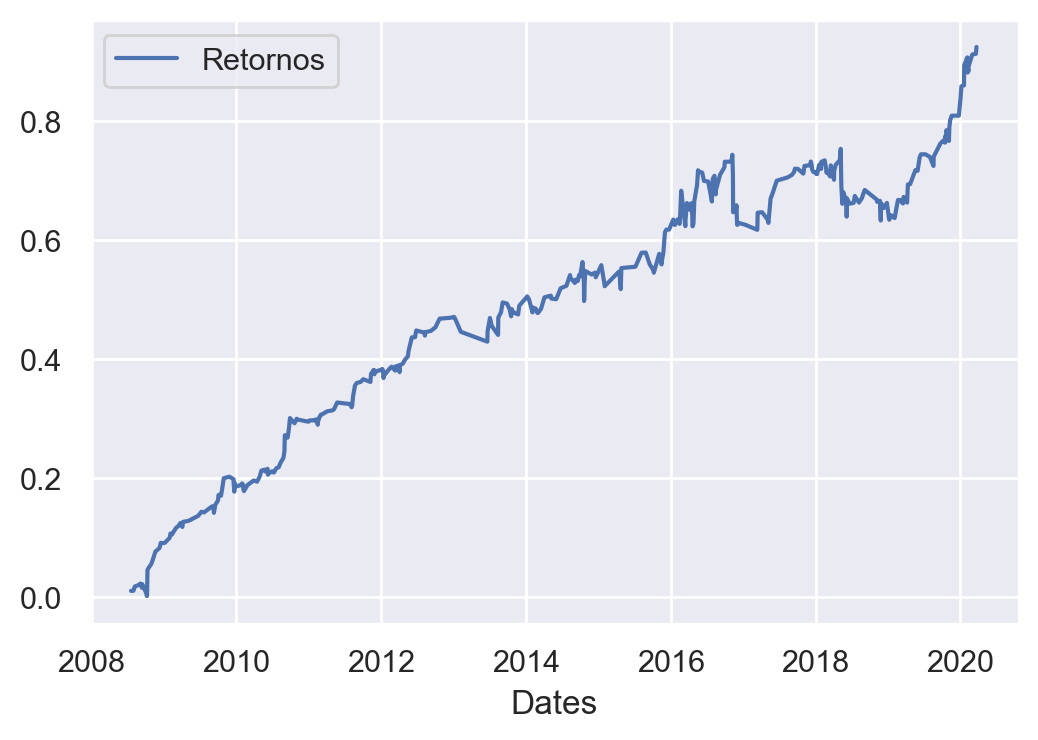

In [43]:
sns.lineplot(data = np.exp(log_retornos1.cumsum())-1)

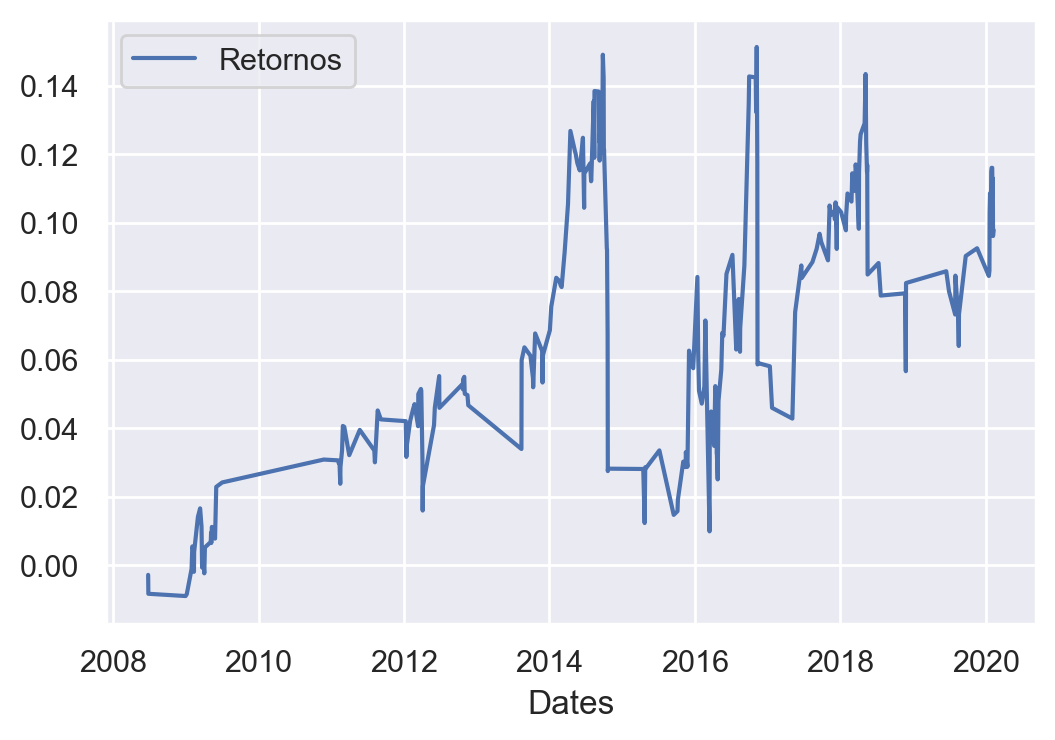

In [125]:
sns.lineplot(data = np.exp(log_retornos2.cumsum())-1)

In [109]:
print(log_retornos1.tail(10))
print(log_retornos2.tail(10))

            Retornos
Dates               
2020-03-16       NaN
2020-03-17       NaN
2020-03-18       NaN
2020-03-19       NaN
2020-03-20       NaN
2020-03-23       NaN
2020-03-24       NaN
2020-03-25       NaN
2020-03-26       NaN
2020-03-27       NaN
            Retornos
Dates               
2020-03-16       NaN
2020-03-17       NaN
2020-03-18       NaN
2020-03-19       NaN
2020-03-20       NaN
2020-03-23       NaN
2020-03-24       NaN
2020-03-25       NaN
2020-03-26       NaN
2020-03-27       NaN


In [87]:
print(len(log_retornos.dropna())/len(log_retornos))

0.07858484658735128


In [77]:
log_retornos.head()

,Retornos
Dates,
2008-01-01,NaN
2008-01-02,NaN
2008-01-03,NaN
2008-01-04,NaN
2008-01-07,NaN


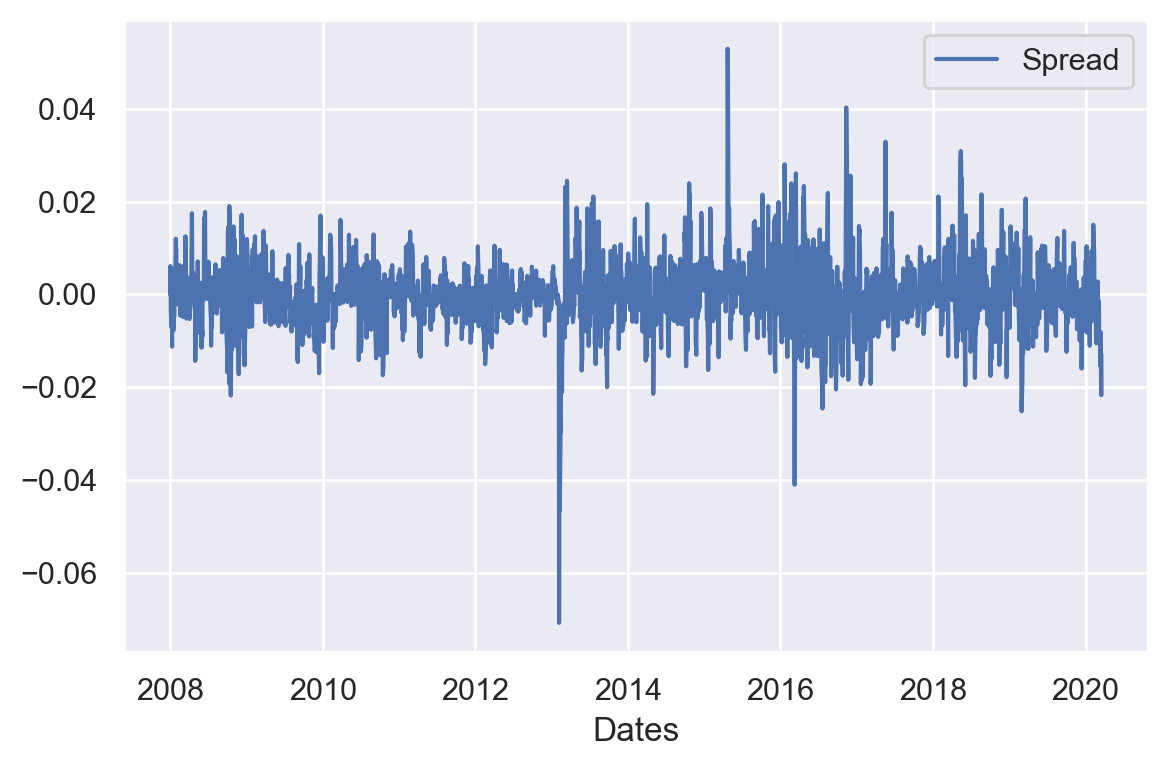

In [183]:
ax = sns.lineplot(data = s)
plt.tight_layout()

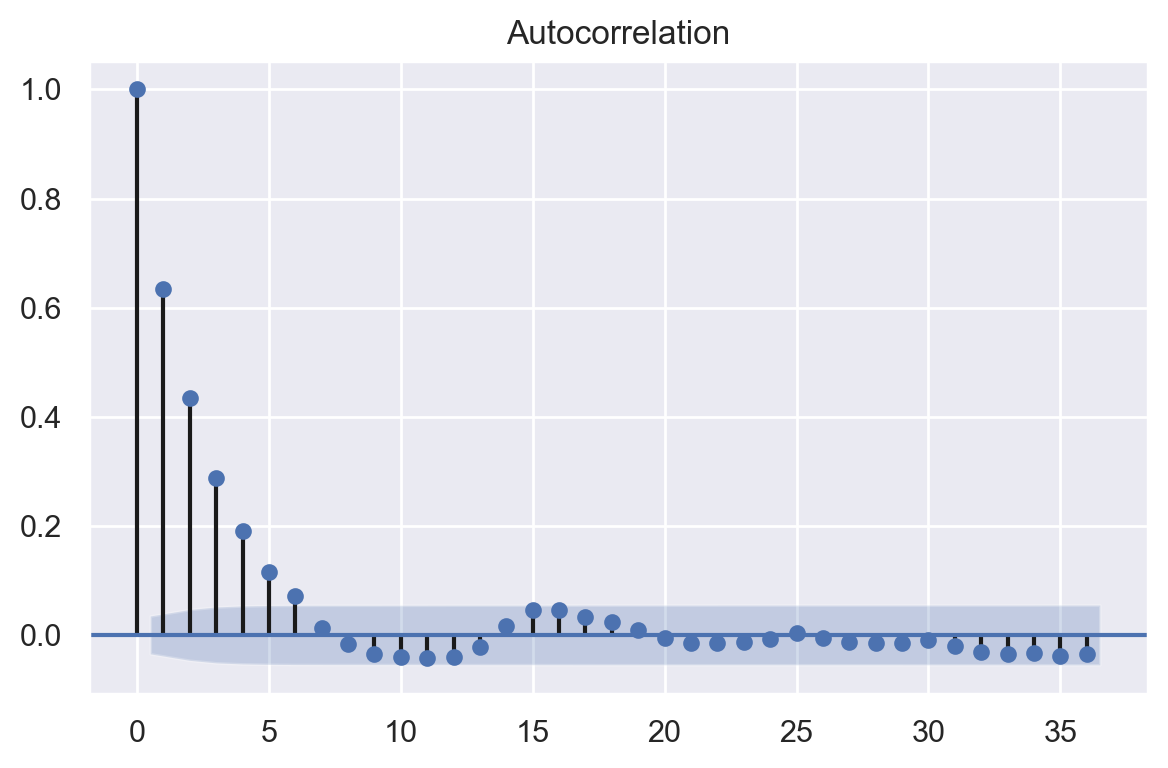

In [184]:
plot_acf(s)
plt.tight_layout()

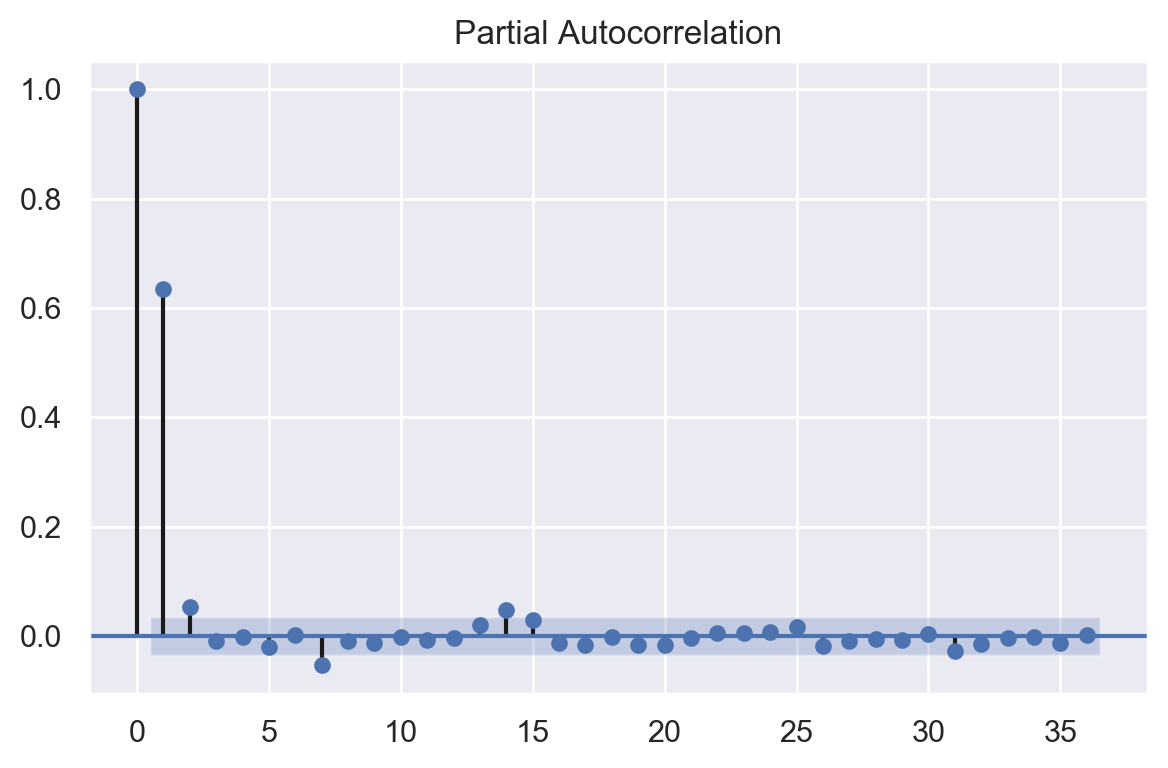

In [185]:
plot_pacf(s)
plt.tight_layout()

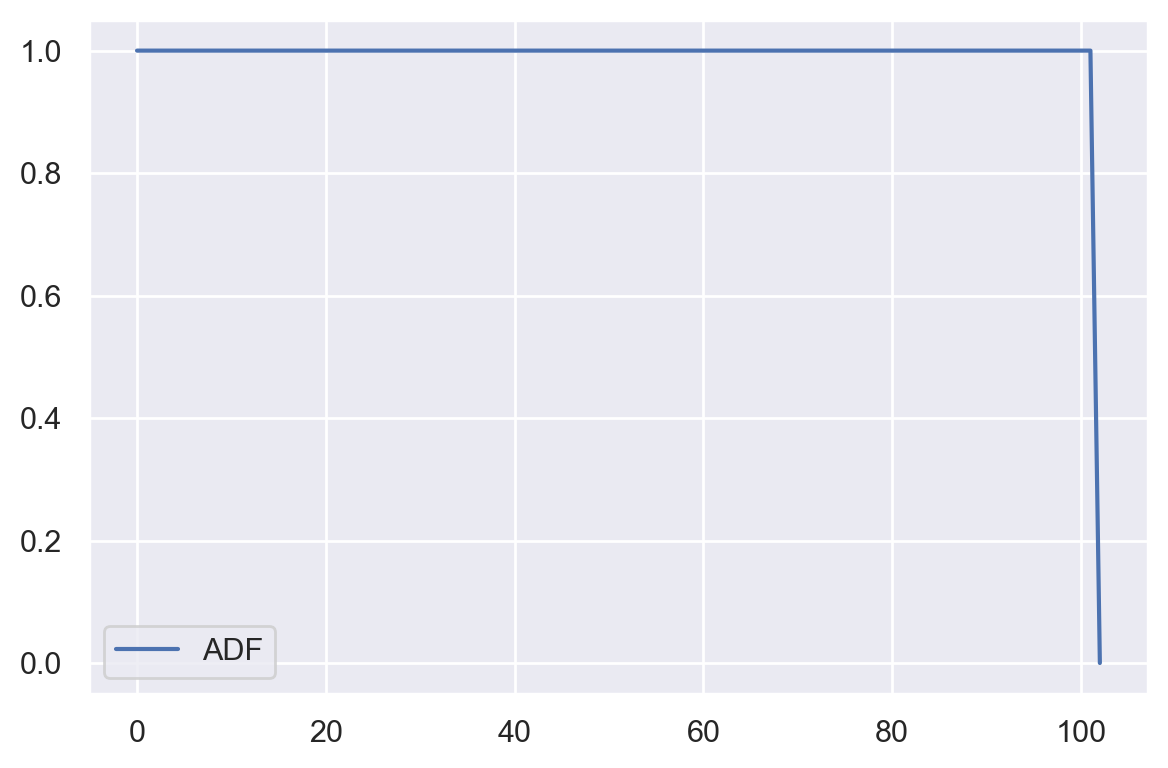

In [186]:
ax = sns.lineplot(data = adf)
plt.tight_layout()

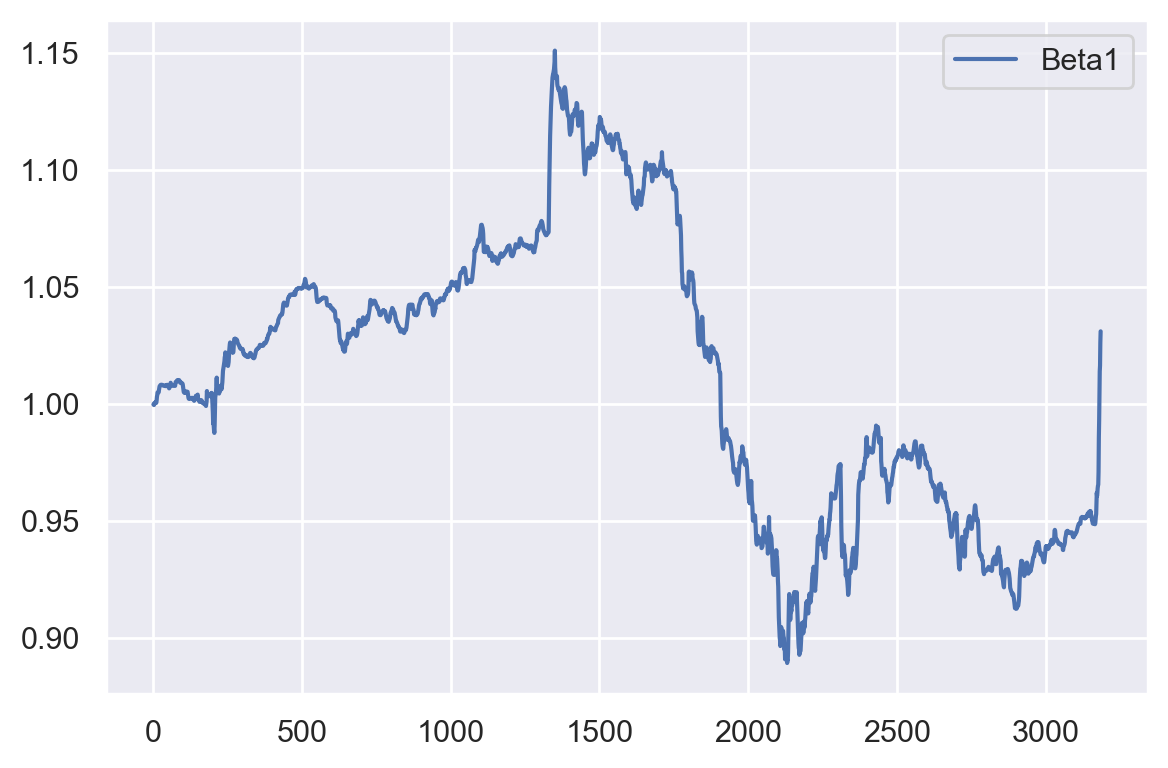

In [189]:
ax = sns.lineplot(data = beta1)
plt.tight_layout()

## Loop Pares

In [ ]:
c1 = 0
c2 = c1 + 1
acoes = list(df_prices.columns.values)

for c1 in range(len(acoes)-2): 

    acao1 = pd.DataFrame(df_log_prices.iloc[:, [c1]])
    acao2 = pd.DataFrame(df_log_prices.iloc[:, [c2]])
    
    res = spread(acao1, acao2, janela_dados, janela_desloc)
    s = res[0]
    adf = res[1]
    johansen = res[2]
    beta0 = res[3]
    beta1 = res[4]
    log_retornos = backtest(acao1, acao2, s, beta0, beta1, adf, janela_dados, janela_desloc, cost, th = 2)
    log_retornos.columns = [acao1.columns + "  vs  " + acao2.columns]
    
    if c1 == 0:
        matriz_log_retornos = log_retornos
    else:
        matriz_log_retornos = pd.concat([matriz_log_retornos, log_retornos], axis=1) 
    
    c1 +=2
    c2 = c1 + 1

In [ ]:
T = matriz_log_retornos.shape[0]
df_fundo_retorno = pd.DataFrame(data = np.zeros(T), index = np.arange(0,T), columns=['Fundo'])
i = 0
for i in np.arange(0, T):
    df_fundo_retorno.iloc[i,0] = np.nanmean(matriz_log_retornos[i,:])

In [ ]:
df_fundo_log_retorno = np.log(1+df_fundo_retorno)
df_fundo_log_retorno['Mes-Ano'] = df_fundo_log_retorno.index.astype(str).str[5:7] + '-' + df_fundo_log_retorno.index.astype(str).str[0:4] # coluna auxiliar para identificar mês e ano
df_fundo_log_retorno_mes = df_fundo_log_retorno.groupby(by = 'Mes-Ano', sort = False).sum()
df_fundo_log_retorno = df_fundo_log_retorno.drop(columns = 'Mes-Ano')
df_fundo_log_retorno_mes.columns = ['Fundo_Log_Retorno_Mes']
df_fundo_retorno_mes = np.exp(df_fundo_log_retorno_mes)-1
df_fundo_retorno_mes.columns = ['Fundo_Retorno_Mes']
print(df_fundo_retorno_mes)
print(df_fundo_log_retorno_mes)
df_fundo_retorno_exc = df_fundo_retorno - df_cdi_retorno
df_fundo_log_retorno_exc = np.log(1+df_fundo_retorno_exc)

In [38]:
T = 100
nomes_fundos = ['Fundo1', 'Fundo2']
df_fundo_retorno = pd.DataFrame(data = np.matrix([np.arange(0,T), np.arange(0,2*T,2)]).T, 
                                        index = np.arange(0,T), columns = nomes_fundos)
df_fundo_retorno.head()

,Fundo1,Fundo2
0,0,0
1,1,2
2,2,4
3,3,6
4,4,8


In [39]:
# Tabelas para guardar as estatísticas
n_fundos = 2
n_estat = 16
df_estat = pd.DataFrame(np.zeros([n_fundos, n_estat]), index = nomes_fundos, 
                        columns = ['Avg', 'DP', 'Min', 'Q1', 'Med', 'Q3', 'Max', 'Range', 
                                   'Skew', 'Kurt', '%_Pos', '%_Neg', '%_Pos_Mes', '%_Neg_Mes', '%_Exc_Pos', '%_Exc_Neg'])
print(df_estat)

        Avg   DP  Min   Q1  Med   Q3  Max  Range  Skew  Kurt  %_Pos  %_Neg  \
Fundo1  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   0.0   0.0    0.0    0.0   
Fundo2  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   0.0   0.0    0.0    0.0   

        %_Pos_Mes  %_Neg_Mes  %_Exc_Pos  %_Exc_Neg  
Fundo1        0.0        0.0        0.0        0.0  
Fundo2        0.0        0.0        0.0        0.0  


In [46]:
# Principais estatísticas (retornos discretos diários)

i = 0
for nome_fundo in nomes_fundos:
    
    df_estat.iloc[i,0] = np.nanmean(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,1] = np.nanstd(np.array(df_fundo_retorno.iloc[:,i]), ddof = 1)
    df_estat.iloc[i,2] = np.min(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,3] = np.nanpercentile(np.array(df_fundo_retorno.iloc[:,i]), 25, axis = 0)
    df_estat.iloc[i,4] = np.nanpercentile(np.array(df_fundo_retorno.iloc[:,i]), 50, axis = 0)
    df_estat.iloc[i,5] = np.nanpercentile(np.array(df_fundo_retorno.iloc[:,i]), 75, axis = 0)
    df_estat.iloc[i,6] = np.max(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,7] = df_estat.iloc[i,6] - df_estat.iloc[i,2]
    df_estat.iloc[i,8] = sp.stats.skew(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,9] = sp.stats.kurtosis(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,10] = df_fundo_retorno.iloc[:,i][df_fundo_retorno.iloc[:,i]>0].count() / df_fundo_retorno.iloc[:,i].count()
    df_estat.iloc[i,11] = 1 - df_estat.iloc[i,10]
    # df_estat.iloc[i,12] = df_fundo_retorno_mes.iloc[:,i][df_fundo_retorno_mes.iloc[:,i]>0].count() / df_fundo_retorno_mes.iloc[:,i].count()
    # df_estat.iloc[i,13] = 1 - df_estat.iloc[i,12]
    # df_estat.iloc[i,14] = df_fundo_retorno_exc.iloc[:,i][df_fundo_retorno_exc.iloc[:,i]>0].count() / df_fundo_retorno_exc.iloc[:,i].count()
    # df_estat.iloc[i,15] = 1 - df_estat.iloc[i,14]
    
    i = i + 1
    
print(df_estat)

         Avg         DP  Min     Q1   Med      Q3    Max  Range  Skew  \
Fundo1  49.5  29.011492  0.0  24.75  49.5   74.25   99.0   99.0   0.0   
Fundo2  99.0  58.022984  0.0  49.50  99.0  148.50  198.0  198.0   0.0   

           Kurt  %_Pos  %_Neg  %_Pos_Mes  %_Neg_Mes  %_Exc_Pos  %_Exc_Neg  
Fundo1 -1.20024   0.99   0.01        0.0        0.0        0.0        0.0  
Fundo2 -1.20024   0.99   0.01        0.0        0.0        0.0        0.0  


In [ ]:
# Retornos acima e abaixo do Benchmark - Base Mensal
if str_tipo_fundo == 'Multimercado':
    df_fundo_retorno_exc_mes = pd.DataFrame(np.array(df_fundo_retorno_mes) - np.array(df_cdi_retorno_mes), 
                                        index = df_fundo_retorno_mes.index)

if str_tipo_fundo == 'Equity':
    df_fundo_retorno_exc_mes = pd.DataFrame(np.array(df_fundo_retorno_mes) - np.array(df_ibov_retorno_mes), 
                                        index = df_fundo_retorno_mes.index)

df_fundo_retorno_exc_mes.columns = ['Fundo_Retorno_Exc']
print(df_fundo_retorno_exc_mes)

fundo_pct_retornos_exc_mes_pos = df_fundo_retorno_exc_mes[df_fundo_retorno_exc_mes>0].count() / df_fundo_retorno_exc_mes.count()
fundo_pct_retornos_exc_mes_pos = np.array(fundo_pct_retornos_exc_mes_pos)
fundo_pct_retornos_exc_mes_neg = 1 - fundo_pct_retornos_exc_mes_pos
print('% Retornos Excedentes Positivos:')
print(fundo_pct_retornos_exc_mes_pos)
print('% Retornos Excedentes Negativos:')
print(fundo_pct_retornos_exc_mes_neg)

In [ ]:
# Melhor / Pior Dia
fundo_retorno_min = (np.min(np.array(df_fundo_retorno)))
print("Retorno Diário Mínimo:")
print(fundo_retorno_min)
dia_retorno_min = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_min].index)
print("Data de Ocorrência do Retorno Diário Mínimo:")
print(dia_retorno_min)

fundo_retorno_max = (np.max(np.array(df_fundo_retorno)))
print("Retorno Diário Máximo:")
print(fundo_retorno_max)
dia_retorno_max = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_max].index)
print("Data de Ocorrência do Retorno Diário Máximo:")
print(dia_retorno_max)